<a href="https://colab.research.google.com/github/qmeng222/transformers-for-NLP/blob/main/Fine_Tuning_Text_Classification_on_Custom_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install libraries:
!pip install transformers datasets
# `transformers` library: for loading, training, and evaluating NLP models
# `datasets` library: for loading, processing, and evaluating datasets

In [2]:
# download dataset from the web:
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv
# `-nc`(no-clobber): prevent `wget` from overwriting an existing file

File ‘AirlineTweets.csv’ already there; not retrieving.



In [3]:
import pandas as pd # `pandas` library for data manipulation and analysis (in DataFrames)
import numpy as np # `numpy` library for numerical computations in Python
import seaborn as sn # `seaborn` library for data visualization
import matplotlib.pyplot as plt # import `pyplot` module (from the `matplotlib` library) for creating plots and charts

import torch # import the PyTorch library for tensor operations

# import functions from the `metrics` module within the `sklearn` library:
# roc_auc_score (Receiver Operating Characteristic Area Under the Curve Scroe) for evaluating binary classification models
# f1_score computes the F1 score for evaluating classification models
# confusion_matrix computes a table that summarizes the performance of a classification model
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# import `train_test_split` function from the `metrics` module within the `sklearn` library
# for splitting a dataset into training and testing subsets:
from sklearn.model_selection import train_test_split

In [4]:
# read data from a Comma Separated Values file & store it in a DataFrame object
# `_` at the end of a variable name is a common convention in Python for naming temporary variable
df_ = pd.read_csv('AirlineTweets.csv')

In [5]:
# retrieve the first 5 rows of the Pandas DataFrame object
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
# create a new DataFrame by copying the selected columns ('airline_sentiment' and 'text'):
df = df_[['airline_sentiment', 'text']].copy()

In [7]:
# retrieve the first 5 rows of the Pandas DataFrame object
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

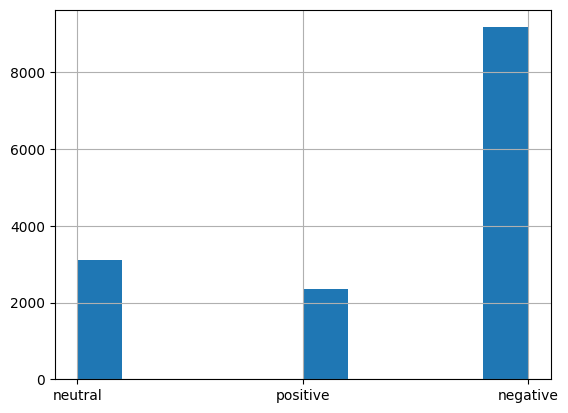

In [8]:
# create a histogram of a specific column in a DataFrame:
df['airline_sentiment'].hist()

👆dominant neg reviews

In [9]:
# map sentiments to numbers in a new col:
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

In [10]:
df.head()

,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [11]:
# create a new DataFrame that includes only the specified columns:
df2 = df[['text', 'target']]
df2.head()

,text,target
0,@VirginAmerica What @dhepburn said.,2
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,2
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [12]:
df2.columns = ['sentence', 'label'] # rename the columns of the DataFrame
print(type(df2))
print(df2.head())

<class 'pandas.core.frame.DataFrame'>
                                            sentence  label
0                @VirginAmerica What @dhepburn said.      2
1  @VirginAmerica plus you've added commercials t...      1
2  @VirginAmerica I didn't today... Must mean I n...      2
3  @VirginAmerica it's really aggressive to blast...      0
4  @VirginAmerica and it's a really big bad thing...      0


In [13]:
df2.to_csv('data.csv', index=None) # export the contents of df2 to a CSV file named 'data.csv'
print(type(df2))

<class 'pandas.core.frame.DataFrame'>


👆 Note: `df2` still retains its type as a Pandas DataFrame

In [14]:
!head data.csv # display the first few lines of the 'data.csv' file

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [15]:
# import `load_dataset` function from the datasets library for downloading datasets:
from datasets import load_dataset

# load dataset from a CSV file named 'data.csv':
raw_dataset = load_dataset('csv', data_files='data.csv')
# load_dataset('csv', data_files=['file1.csv', 'file2.csv']) # for multi files

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [16]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [17]:
raw_dataset["train"]

Dataset({
    features: ['sentence', 'label'],
    num_rows: 14640
})

In [18]:
raw_dataset["train"].features

{'sentence': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [19]:
raw_dataset["train"].num_rows

14640

In [20]:
raw_dataset.shape

{'train': (14640, 2)}

In [21]:
raw_dataset.data

{'train': MemoryMappedTable
 sentence: string
 label: int64
 ----
 sentence: [["@VirginAmerica What @dhepburn said.","@VirginAmerica plus you've added commercials to the experience... tacky.","@VirginAmerica I didn't today... Must mean I need to take another trip!","@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse","@VirginAmerica and it's a really big bad thing about it",...,"@united by the time I finally get to Dallas I could have driven with less frustration and cheaper.","@united I'm trying to get to my final destination, we need compensation. Just about 2hrs of personal time wasted.","@united that guy really has no customer service clue.Could have spent effort clearing bins for rollerboards instead of art projects in mine!","@united he has no priority and Iove it","@united Pleased to be a Premier Platinum"],["@united how can you not put my bag on plane to Seattle. Flight 1212. Waiting  in line to talk to

# Split the data:

In [22]:
# split the 'train' dataset into 'train' and 'test' sets using the `train_test_split` method:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42) # 30% for testing & ensure the random splitting process is deterministic (always get the same split)

In [23]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

👆 14640 x 0.3 = 4392, 14640 - 4392 = 10248

In [24]:
# # if you have multiple csv files:
# load_dataset('csv', data_files=['file1.csv', 'file2.csv'])

# # if you already have a train-test split:
# load_dataset(
#     'csv',
#     data_files={'train': ['train1.csv', 'train2.csv'],
#                 'test': 'test.csv'
#     }
# )

# Tokenize:

In [25]:
from transformers import AutoTokenizer # import `AutoTokenizer` class to automatically load the appropriate tokenizer for a specific pre-trained model

In [26]:
checkpoint = 'distilbert-base-cased' # model name

In [27]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint) # load the appropriate tokenizer

In [28]:
def tokenize_fn(batch):
  # takes a batch of examples & tokenize the 'sentence' field of each example
  # truncate the tokens if they exceed the maximum token length supported by the tokenizer
  return tokenizer(batch['sentence'], truncation=True)

In [29]:
# apply the above `tokenize_fn` func to each batch in the splitted DatasetDict (`split`)
tokenized_datasets = split.map(tokenize_fn, batched=True)
# batched=True: `tokenize_fn` should be applied to batches of examples, not individual examples
# "batch" refers to batches of examples within the training and testing sets

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [30]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4392
    })
})

In [31]:
# import classes from the HF transformers library:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
# `AutoModelForSequenceClassification` class: for sequence classification tasks
# `Trainer` calss: for training and evaluating models
# `TrainingArguments` class: to define and customize the training arguments (hyperparameters etc.) for the training process

In [32]:
# instantiate the model by loading pre-trained weights and specifying the number of classification labels:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Display a summary of the model:

In [33]:
# install the `torchinfo` library for printing info about PyTorch models (layer shapes, parameter counts, etc):
!pip install torchinfo

# import `summary` function to print a summary of the PyTorch model
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [34]:
# install additional dependencies related to PyTorch:
!pip install transformers[torch]

In [35]:
# create an instance of the `TrainingArguments` class with specific configuration settings:
training_args = TrainingArguments(
  output_dir='training_dir', #  specify the directory where the trained model and associated files will be saved
  evaluation_strategy='epoch', # evaluation (validation) will be performed at the end of each epoch
  save_strategy='epoch', # the model will be saved at the end of each epoch
  num_train_epochs=3, # the model will be trained for 3 epochs
  per_device_train_batch_size=16, # batch size for training (how many training examples will be processed in each forward and backward pass)
  per_device_eval_batch_size=64, # batch size for evaluation
)

In [36]:
# function for computing evaluation metrics based on the logits (raw predictions) and true labels
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels # unpack the tuple, which is provided by the evaluation loop of a model
  predictions = np.argmax(logits, axis=-1) # (for classification purpose) compute the predictions by taking the index of the maximum logit along the last axis
  acc = np.mean(predictions == labels) # compute the ave accuracy
  f1 = f1_score(labels, predictions, average='macro') # compute the F1 score
  return {'accuracy': acc, 'f1': f1} # return a dict containing the computed metrics

In [37]:
# configure an instance of the `Trainer` class:
trainer = Trainer(
    model, # the model to be trained or fine-tuned (the model created using `AutoModelForSequenceClassification.from_pretrained()`)
    training_args, # the instance of the TrainingArguments class
    train_dataset=tokenized_datasets["train"], # refer to the `tokenized_datasets`
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer, # the tokenizer loaded to preprocess the input data
    compute_metrics=compute_metrics, # the func for computing evaluation metrics
)

In [38]:
# train the model (forward, backward, update params, logging, eval):
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.536100,0.426504,0.832650,0.770616
2,0.347300,0.477693,0.840164,0.780349
3,0.224200,0.644578,0.839709,0.789418


TrainOutput(global_step=1923, training_loss=0.3214510095906766, metrics={'train_runtime': 195.0484, 'train_samples_per_second': 157.622, 'train_steps_per_second': 9.859, 'total_flos': 387616869956304.0, 'train_loss': 0.3214510095906766, 'epoch': 3.0})

In [40]:
# lists the contents of the `training_dir` directory:
!ls training_dir

checkpoint-1282  checkpoint-1923  checkpoint-641  runs


In [41]:
# from `transformers` library import the `pipeline` function to use pre-trained models:
from transformers import pipeline

In [42]:
# create a text classification pipeline that uses a previously trained model checkpoint
savedmodel = pipeline('text-classification', # specify the task for the pipeline
                      model='training_dir/checkpoint-1282', # specify the path of the pre-trained model
                      device=0) # GPU go first

In [45]:
# 'train' and 'test' sets:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [44]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [46]:
split['test'].shape

(4392, 2)

In [47]:
# apply the `savedmodel` text classification pipeline to the `sentence` col:
test_pred = savedmodel(split['test']['sentence'])

In [48]:
# the `test_pred` variable is a list of predictions for the test sentences:
test_pred

[{'label': 'LABEL_1', 'score': 0.9347352981567383},
 {'label': 'LABEL_1', 'score': 0.9238209128379822},
 {'label': 'LABEL_1', 'score': 0.7951321601867676},
 {'label': 'LABEL_1', 'score': 0.8713523745536804},
 {'label': 'LABEL_2', 'score': 0.7648181319236755},
 {'label': 'LABEL_0', 'score': 0.9961250424385071},
 {'label': 'LABEL_2', 'score': 0.7951288819313049},
 {'label': 'LABEL_2', 'score': 0.7661386728286743},
 {'label': 'LABEL_1', 'score': 0.7862540483474731},
 {'label': 'LABEL_0', 'score': 0.9955139756202698},
 {'label': 'LABEL_0', 'score': 0.9929395914077759},
 {'label': 'LABEL_0', 'score': 0.9941978454589844},
 {'label': 'LABEL_1', 'score': 0.9691969752311707},
 {'label': 'LABEL_0', 'score': 0.9956240057945251},
 {'label': 'LABEL_2', 'score': 0.9754005670547485},
 {'label': 'LABEL_2', 'score': 0.8146871328353882},
 {'label': 'LABEL_1', 'score': 0.46318283677101135},
 {'label': 'LABEL_0', 'score': 0.9971087574958801},
 {'label': 'LABEL_0', 'score': 0.9690695405006409},
 {'label': 

👆 `test_pred` is a list of dictionaries

In [50]:
len(test_pred)

4392

In [53]:
len(test_pred[0]) # label & score

2

In [54]:
# extract numerical label (0 or 1 or 2) from the 'label' field:
def get_label(d):
  return int(d['label'].split('_')[1]) # eg: {'label': 'LABEL_1', 'score': 0.9539570808410645} -> 1

# a list of numerical labels:
test_pred = [get_label(d) for d in test_pred] # d for dictionary

In [55]:
# calculate the accuracy of the model's predictions on the test set labels:
print("acc:", accuracy_score(split['test']['label'], test_pred))

acc: 0.8401639344262295


In [57]:
# calculate the macro-averaged F1 score of the model's predictions on the test set labels:
print("f1:", f1_score(split['test']['label'], test_pred, average='macro'))

f1: 0.7803491912365162


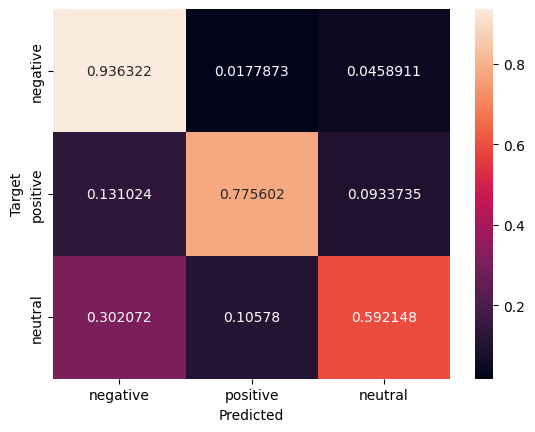

In [58]:
# plot confusion matrix:
def plot_cm(cm):
  classes = ['negative', 'positive', 'neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

cm = confusion_matrix(split['test']['label'], test_pred, normalize='true')
plot_cm(cm)

👆 It's logical that the diagonal values in the confusion matrix are higher.